In [49]:
# Import modules

import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt


In [ ]:
# Load data
# data = pd.read_csv('data.csv')
data = pd.read_csv('data\planning_historic_actuals.csv')
data_52wks = data[data['MeasureID'] == 1013]

# Unpivot data
data_52wks = pd.melt(data_52wks, id_vars=data_52wks.columns[1:7], value_vars=data_52wks.columns[8:])

# Rename month column, filter error months, and set data type to date
data_52wks.rename(columns={'variable': 'date'}, inplace=True)
data_52wks = data_52wks.loc[data_52wks['date'].str.len() == 6]
data_52wks['date'] = pd.to_datetime(data_52wks['date'], format='%b-%y')

data_52wks.head()

,OrgType,ICBCode,RegionCode,MeasureID,MeasureName,MeasureType,date,value
0,Provider,QOP,Y62,1013.0,RTT Waiting List,Total 52 plus weeks,2023-05-01,28828.0
1,Provider,QHM,Y63,1013.0,RTT Waiting List,Total 52 plus weeks,2023-05-01,326.0
2,Provider,QVV,Y58,1013.0,RTT Waiting List,Total 52 plus weeks,2023-05-01,4810.0
3,Provider,QRL,Y59,1013.0,RTT Waiting List,Total 52 plus weeks,2023-05-01,893.0
4,Provider,QMF,Y56,1013.0,RTT Waiting List,Total 52 plus weeks,2023-05-01,7275.0


In [53]:
# Sum value to region total
data_52wks_forecast = data_52wks.groupby('date')['value'].sum().reset_index()

# Remove 'zero' data
data_52wks_forecast = data_52wks_forecast[data_52wks_forecast['value'] != 0]

c:\Users\martin.bloyce2\AppData\Local\anaconda3\envs\hsma_forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\martin.bloyce2\AppData\Local\anaconda3\envs\hsma_forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\martin.bloyce2\AppData\Local\anaconda3\envs\hsma_forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\martin.bloyce2\AppData\Local\anaconda3\envs\hsma_forecast\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary

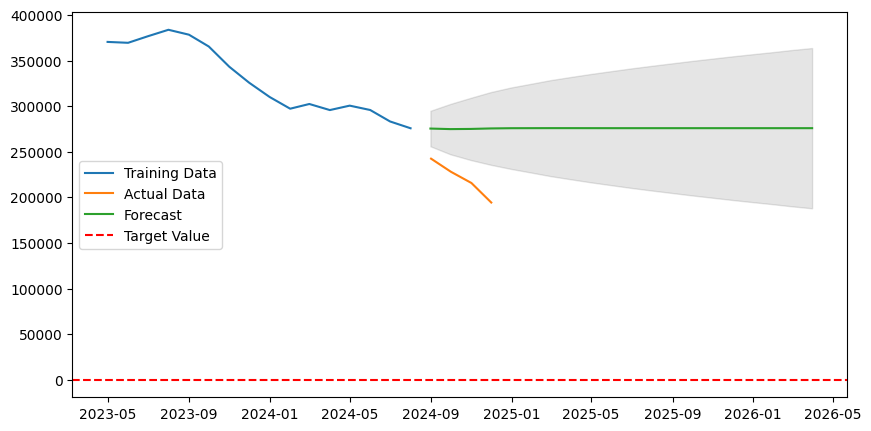

Probability of hitting the target by 2026-03-31: 0.00%


In [54]:

# Ensure the date column is parsed as datetime and set as index
# data_52wks_forecast['date'] = pd.to_datetime(data_52wks_forecast['date'])
data_52wks_forecast = data_52wks_forecast.set_index('date')

# Ensure data is in monthly frequency
data_52wks_forecast.resample('M').mean()

# Select the column to use for ARIMA model
endog = data_52wks_forecast['value']

# Define the target date and value
target_date = '2026-03-31'
target_value = 100

# Split data into training and testing sets
train = data_52wks_forecast[:int(0.8*len(data_52wks_forecast))]
test = data_52wks_forecast[int(0.8*len(data_52wks_forecast)):]

# Fit ARIMA model
model = ARIMA(train, order=(5,1,0))
model_fit = model.fit()

# Forecast up to the target date
forecast_steps = (pd.to_datetime(target_date) - train.index[-1]).days // 30
forecast_result = model_fit.get_forecast(steps=forecast_steps)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Create a date range for the forecast
forecast_index = pd.date_range(start=train.index[-1], periods=forecast_steps, freq='M')

# Plot forecast with confidence intervals
plt.figure(figsize=(10,5))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Data')
plt.plot(forecast_index, forecast, label='Forecast')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='k', alpha=0.1)
plt.axhline(y=target_value, color='r', linestyle='--', label='Target Value')
plt.legend()
plt.show()

# Calculate probability of hitting target on the target date
target_conf_int = conf_int.iloc[-1]  # Confidence interval on the target date
probability = np.mean((target_conf_int[0] <= target_value) & (target_conf_int[1] >= target_value))
print(f'Probability of hitting the target by {target_date}: {probability*100:.2f}%')